In [ ]:
%tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
1.15.2


In [ ]:
# 需要安裝 keras 2.2.4 的版本, 否則訓練時會出現 error
!pip install keras==2.2.4

     |████████████████████████████████| 317kB 10.7MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [ ]:
import keras
print(keras.__version__)

2.2.4


Using TensorFlow backend.


In [7]:
from google.colab import drive
drive.mount('/content/gdrive') # 將 google drive 掛載在 colob

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [8]:
%cd '/content/gdrive/My Drive'

# 下載基於 keras 的 yolov3 程式碼
import os
if not os.path.exists("keras-yolo3") :
  !git clone https://github.com/qqwweee/keras-yolo3
else :
  print("keras-yolo3 exists")

%cd keras-yolo3
!ls

/content/gdrive/My Drive
keras-yolo3 exists
/content/gdrive/My Drive/keras-yolo3
annotation_xml	    Kangaroo_new.mp4  Raccoon_new.mp4	   val_labels.txt
class.txt	    kmeans.py	      README.md		   voc_annotation.py
coco_annotation.py  LICENSE	      test		   yolo3
convert.py	    logs	      train		   yolo.py
darknet53.cfg	    model_data	      train_bottleneck.py  yolov3.cfg
font		    __pycache__       train_labels.txt	   yolov3-tiny.cfg
kangaroo	    raccoon_dataset   train.py		   yolov3.weights
Kangaroo.mp4	    Raccoon.mp4       val		   yolo_video.py


In [ ]:
# model_data/yolo.h5 模型 & 權重
# 下載 yolov3 的網路權重，並且把權重轉換為 keras 能夠讀取的格式
if not os.path.exists("model_data/yolo.h5"):
  # 下載 yolov3 的網路權重
  print("Model doesn't exist, downloading...")
  os.system("wget https://pjreddie.com/media/files/yolov3.weights")
  
  # 把權重轉換為 keras 能夠讀取的格式(.h5)
  print("Converting yolov3.weights to yolo.h5...")
  os.system("python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5")
else:
  print("Model exist")

Model doesn't exist, downloading...
Converting yolov3.weights to yolo.h5...


下載 raccoon 與 kangaroo 的資料集

In [ ]:
# 下載 raccoon 與 kangaroo 的資料集
if not os.path.exists("raccoon_dataset"):
  !git clone https://github.com/experiencor/raccoon_dataset.git  # 下載 raccoon_dataset 資料集
else:
  print("raccoon_dataset exists")

if not os.path.exists("kangaroo"):
  !git clone https://github.com/experiencor/kangaroo.git  # 下載 kangaroo 資料集
else:
  print("kangaroo exists")

Cloning into 'raccoon_dataset'...
remote: Enumerating objects: 646, done.
remote: Total 646 (delta 0), reused 0 (delta 0), pack-reused 646
Receiving objects: 100% (646/646), 48.00 MiB | 7.58 MiB/s, done.
Resolving deltas: 100% (412/412), done.
Checking out files: 100% (419/419), done.
Cloning into 'kangaroo'...
remote: Enumerating objects: 334, done.
remote: Total 334 (delta 0), reused 0 (delta 0), pack-reused 334
Receiving objects: 100% (334/334), 18.39 MiB | 1.45 MiB/s, done.
Resolving deltas: 100% (158/158), done.
Checking out files: 100% (329/329), done.


把標註資料轉換為訓練模型時需要的格式，參考 https://github.com/qqwweee/keras-yolo3/blob/master/voc_annotation.py 

In [ ]:
# # 為了比較資料集的大小對物體檢測結果的影響，這裡增加了資料集擴增的實作
# # raccoon jpg 檔數量: 200 => 400
# # kangaroo jpg 檔數量: 164 => 328
# # 所有 jpg 檔數量: 364 => 728
# from keras.preprocessing.image import ImageDataGenerator
# img_gen = ImageDataGenerator(rotation_range=20,width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, dtype=np.float32)

# train_set = img_gen.flow_from_directory(from_path, batch_size=16, shuffle=False, save_to_dir=augment_path, save_prefix='augment', save_format='jpg', target_size=(416, 416), class_mode='categorical')

In [ ]:
import numpy as np
# 訓練模型時需使用的 annotation 檔名, 若已經做好轉換, 則不會每次再重新跑這段轉換的程式碼
if not os.path.exists("train_labels.txt"):
  import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
  
  sets=['train', 'val']

  # "raccoon", "kangaroo" 的資料類別
  classes = ["raccoon", "kangaroo"]

  # 把 annotation(.xml) 轉換到訓練時需要的資料形態
  def convert_annotation(image_id, list_file):
      in_file = open('annotation_xml/%s.xml'%(image_id))
      tree=ET.parse(in_file)
      root = tree.getroot()

      for obj in root.iter('object'):
          difficult = obj.find('difficult').text
          cls = obj.find('name').text
          if cls not in classes or int(difficult)==1: 
              continue
          cls_id = classes.index(cls)  # class index
          xmlbox = obj.find('bndbox')
          b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), 
                int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
          list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

  # 把 raccoon_dataset/images 與 kangaroo/images 檔案合併後, 當成訓練集 & 驗證集資料
  for root,dirs,files in os.walk('raccoon_dataset/images') :
    print('raccoon jpg 檔數量:', len(files))
  for root_2,dirs_2,files_2 in os.walk('kangaroo/images') :
    print('kangaroo jpg 檔數量:', len(files_2))
  # 把 files_2 合併在 files list 內
  files.extend(files_2)
  print('所有 jpg 檔數量:', len(files))
    
  jpg_ids = ''.join(files).strip().split('.jpg')[:-1]
  # 80% 檔案資料當成訓練集資料
  train_index = np.random.choice(jpg_ids, size=int(len(jpg_ids)*0.8), replace=False)
  val_index = np.setdiff1d(jpg_ids, train_index)

  !mkdir train val
  # 把訓練集資料檔索引, 放入 train 資料夾
  train_txt = open('train/train.txt', 'w')
  print("save train index at train/train.txt")       
  for train_id in train_index : 
      train_txt.write('%s' %(train_id))
      train_txt.write('\n')
  train_txt.close()

  # 把驗證集資料檔索引, 放入 val 資料夾
  val_txt = open('val/val.txt', 'w')
  print("save val index at val/val.txt")       
  for val_id in val_index : 
      val_txt.write('%s' %(val_id))
      val_txt.write('\n')
  val_txt.close()

  # 把annotation(.xml), 放入 annotation_xml 資料夾
  !mkdir annotation_xml
  !cp raccoon_dataset/annotations/*.xml ./annotation_xml
  !cp kangaroo/annots/*.xml ./annotation_xml

  # 把類別資料放入 class.txt
  class_txt = open('class.txt', 'w')
  print("save class at class.txt")       
  for class_id in classes : 
      class_txt.write('%s' %(class_id))
      class_txt.write('\n')
  class_txt.close()

  for image_set in sets:
      image_ids = open('%s/%s.txt'%(image_set, image_set)).read().strip().split()
      
      annotation_path = '%s_labels.txt'%(image_set)
      list_file = open(annotation_path, 'w')
      print("save annotation at %s" % annotation_path)
      # 處理訓練集 & 驗證集資料檔
      for image_id in image_ids:
        if 'raccoon' in image_id :
          list_file.write('./raccoon_dataset/images/%s.jpg' %(image_id))
        else :
          list_file.write('./kangaroo/images/%s.jpg' %(image_id))  
        convert_annotation(image_id, list_file)
        list_file.write('\n')
      list_file.close()

raccoon jpg 檔數量: 200
kangaroo jpg 檔數量: 164
所有 jpg 檔數量: 364
save train index at train/train.txt
save val index at val/val.txt
save class at class.txt
save annotation at train_labels.txt
save annotation at val_labels.txt


把 YOLO weights 轉換為 keras 訓練新模型的初始權重，注意要加一個 -w 參數

In [ ]:
# convert.py '-w' : 代表只轉換權重 weights 到 model_data/yolo_weights.h5
if not os.path.exists("model_data/yolo_weights.h5"):
  print("Converting pretrained YOLOv3 weights for training")
  os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
  print("Pretrained weights exists")

Converting pretrained YOLOv3 weights for training


In [ ]:
# 將 train.py 所需要的套件載入
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

In [ ]:
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

In [ ]:
# 因訓練時發生 error, 故加入此程式碼 :
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
annotation_path_train = 'train_labels.txt' # 轉換好格式的 train 標註檔案
annotation_path_val = 'val_labels.txt' # 轉換好格式的 val 標註檔案
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
classes_path = 'class.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=30)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

with open(annotation_path_train) as f:
    lines_train = f.readlines()
with open(annotation_path_val) as f:
    lines_val = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines_train)
np.random.shuffle(lines_val)
np.random.seed(None)
num_train = len(lines_train)  # 訓練資料(80%)
num_val = len(lines_val)      # 驗證資料(20%)

# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model_1= model.fit_generator(data_generator_wrapper(lines_train, batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines_val, batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint, reduce_lr])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

# Unfreeze and continue training, to fine-tune.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 16 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    hist_model= model.fit_generator(data_generator_wrapper(lines_train, batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines_val, batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    
    model.save_weights(log_dir + 'trained_weights_final.h5')














Create YOLOv3 model with 9 anchors and 2 classes.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:1140: UserWarning: Skipping loading of weights for layer conv2d_75 due to mismatch in shape ((1,

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 291 samples, val on 73 samples, with batch size 16.




Epoch 1/50
18/18 [==============================] - 34s 2s/step - loss: 4734.4210 - val_loss: 1263.6010

Epoch 2/50
18/18 [==============================] - 21s 1s/step - loss: 764.5037 - val_loss: 362.6295
Epoch 3/50
18/18 [==============================] - 23s 1s/step - loss: 312.9871 - val_loss: 218.2032
Epoch 4/50
18/18 [==============================] - 23s 1s/step - loss: 207.2469 - val_loss: 156.1545
Epoch 5/50
18/18 [==============================] - 23s 1s/step - loss: 161.2035 - val_loss: 128.7648
Epoch 6/50
18/18 [==============================] - 23s 1s/step - loss: 131.7442 - val_loss: 105.8163
Epoch 7/50
18/18 [==============================] - 23s 1s/step - loss: 113.7679 - val_loss: 92.8573
Epoch 8/50
18/18 [===============

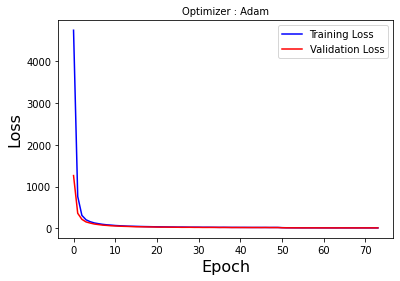

In [ ]:
# 劃出 loss 值的圖
import matplotlib.pyplot as plt
%matplotlib inline
model_1.history['loss'] + hist_model.history['loss']

plt.title('Optimizer : Adam', fontsize=10)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.plot(model_1.history['loss'] + hist_model.history['loss'], color='b', label='Training Loss')
plt.plot(model_1.history['val_loss'] + hist_model.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

In [9]:
# %tensorflow_version 1.x # 確保 colob 中使用的 tensorflow 是 1.x 版本而不是 tensorflow 2
# import tensorflow as tf
# import keras

# from google.colab import drive
# drive.mount('/content/gdrive') # 將 google drive 掛載在 colob
# %cd keras-yolo3

[Errno 2] No such file or directory: 'keras-yolo3'
/content/gdrive/My Drive/keras-yolo3


In [10]:
# 畫出多張預測圖

# 使用預訓練的權重來偵測物體
from yolo import YOLO
classes_path = 'class.txt'
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑
yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)

image_list1, image_list2 = [], []
for img in range(6) :
  image_list1.append('test/kangaroo_000' + str(img) +'.jpg')
for img in range(6) :
  image_list2.append('test/raccoon_000' + str(img) +'.jpg')
image_list2.extend(image_list1)

from PIL import Image
import matplotlib.pyplot as plt
for idx, im in enumerate(image_list2) :
    r_image = yolo_model.detect_image(Image.open(im))  
    display(r_image)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# 偵測 Kangaroo.mp4 
from yolo import YOLO
import numpy as np
import time
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

classes_path = 'class.txt'
log_dir = 'logs/000/' # 訓練好的模型儲存的路徑

yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)

def detect_video(yolo, video_path, output_path=""):
    import cv2
    vid = cv2.VideoCapture(video_path)
    if not vid.isOpened():
        raise IOError("Couldn't open webcam or video")
    video_FourCC    = int(vid.get(cv2.CAP_PROP_FOURCC))
    # 指定 video 編碼方式(此例使用 MP4)
    video_FourCC = cv2.VideoWriter_fourcc(*'MP4V')
    video_fps       = vid.get(cv2.CAP_PROP_FPS) 
    video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),
                        int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    isOutput = True if output_path != "" else False
    if isOutput:
        out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)
    video_cnt = 0  
    video_playtime = []  
    while True:
        return_value, frame = vid.read()
        video_cnt += 1 
        if return_value == True : 
            image = Image.fromarray(frame)
            start_time = time.time() 
            image = yolo.detect_image(image)
            end_time = time.time()
            time_img = end_time - start_time  
            video_playtime.append(round(time_img, 3)) 
            result = np.asarray(image)
            cv2.putText(result, text='fps', org=(3, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=0.50, color=(255, 0, 0), thickness=2)
            if isOutput:
                out.write(result)
        else :  
            break
    vid.release()  # release vid resource
    out.release()  # release out resource
    return video_playtime, video_cnt 

# 1.偵測 Kangaroo.mp4
video_playtime, video_cnt = detect_video(yolo_model, video_path="Kangaroo.mp4", output_path="Kangaroo_new.mp4")
print('Kangaroo.mp4 total frames: ', video_cnt)  # 總共有多少 frames

# Kangaroo 平均 fps :
avg_fps = 1/np.mean(video_playtime)
print("Kangaroo.mp4 avg fps: %.3f" % avg_fps)

Streaming output truncated to the last 5000 lines.
kangaroo 0.85 (717, 323) (998, 519)
0.05948902500040276
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.54 (116, 244) (743, 673)
kangaroo 0.64 (329, 314) (975, 720)
0.05401066200010973
(416, 416, 3)
Found 0 boxes for img
0.049747322000257554
(416, 416, 3)
Found 0 boxes for img
0.052413976000025286
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.79 (261, 230) (1003, 647)
0.05245421899962821
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.49 (337, 295) (950, 576)
0.052923962000022584
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.59 (503, 263) (929, 632)
0.05310431599991716
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.61 (377, 303) (907, 583)
0.05135240299932775
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.62 (380, 305) (907, 582)
0.052023365999957605
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (334, 247) (944, 636)
0.05275808500027779
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.71 (0, 332) (657, 576)
kangaroo 0.87 (338, 264) (

In [ ]:
# 2.偵測 Raccoon.mp4
video_playtime, video_cnt = detect_video(yolo_model, video_path="Raccoon.mp4", output_path="Raccoon_new.mp4")
print('Raccoon.mp4 total frames: ', video_cnt)  # 總共有多少 frames

# Raccoon 平均 fps :
avg_fps = 1/np.mean(video_playtime)
print("Raccoon.mp4 avg fps: %.3f" % avg_fps)

Streaming output truncated to the last 5000 lines.
(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (0, 30) (1280, 680)
0.05262076100007107
(416, 416, 3)
Found 1 boxes for img
raccoon 0.77 (0, 45) (1280, 662)
0.051639536999573465
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (0, 40) (1280, 667)
0.051743619999797374
(416, 416, 3)
Found 1 boxes for img
raccoon 0.74 (0, 41) (1280, 666)
0.05230608400052006
(416, 416, 3)
Found 1 boxes for img
raccoon 0.70 (0, 35) (1280, 673)
0.05240962599964405
(416, 416, 3)
Found 1 boxes for img
raccoon 0.68 (0, 25) (1280, 683)
0.056458813000062946
(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (0, 46) (1280, 661)
0.05032700100036891
(416, 416, 3)
Found 1 boxes for img
raccoon 0.59 (0, 64) (1280, 637)
0.051671239999450336
(416, 416, 3)
Found 1 boxes for img
raccoon 0.51 (0, 54) (1280, 651)
0.05379470899970329
(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (0, 50) (1280, 656)
0.051095178000650776
(416, 416, 3)
Found 1 boxes for img
raccoon 0.40 (0, 6